# Project 1: Image and Video Classification,
# Part II - Image Classification


 - **Student Name**: 

 - **Finish Date**: 

Points Distribution: 
- Task1: 5 
- Task2: 10
- Task3: 10
- Task4: 10
- Task5: 15

## Task 0: Getting Started

The goal of this project is to implement the *“Hello World!”* program of deep learning: designing and training a network that performs image classification. The dataset we will be using is CIFAR10 which is a large set of images that are classified into 10 classes (airplane, bird, cat, etc.).

Most of the code is adapted from PyTorch Tutorial. Please view this page if you meet any issue: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

Now please **follow the tasks and fill in the blanks**.

In [ ]:
# load packages
from __future__ import print_function, division

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode


## Task 1:  Data Loading (5 points)
Complete the **DataLoader** below which we will use to load images of the cifar10 dataset provided by torchvision. Your task is to normalize it by shifting and scaling it by a factor of 0.5. For the training set, introduce random transformations (e.g. flips) for data augmentation.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for testing
data_transforms = {
    'train': transforms.Compose([
        # TODO 1, data transform for train set. Use RandomHorizontalFlip function for data augumentation
        ################################ TODO ##################################
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
        ################################ TODO ##################################
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
}

# Load CIFAR10
image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'), download=True, transform=data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=(x=='train'), num_workers=16) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# Move to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations. The results should look like:

<img src="https://i.imgur.com/Sa6l1go.png" width="400" align="left">

torch.Size([32, 3, 32, 32])


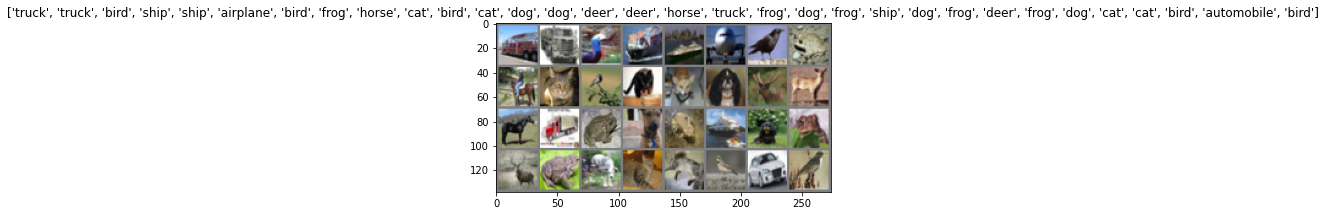

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


## Task 2: Basic Networks (10 points)

### Task 2.1. Create a Fully connected Network (FcNet) as follows in the Jupyter Notebook:
```
FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
```

In [ ]:
In_F1 = 3072
Out_F1 = 1024
Out_F2 = 400
Out_F3 = 84
Out_F4 = 10

In [ ]:
# Task2.1. Define a Fully Connected Neural Network
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        # TODO Task 2:  Define the layers 
        ################################ TODO ##################################
        self.fc1 = nn.Linear(32,1024,bias=True)
        self.fc2 = nn.Linear(1024,400,bias=True)
        self.fc3 = nn.Linear(400,84,bias=True)
        self.fc4 = nn.Linear(84,10,bias=True)
        self.relu = nn.ReLU()
        ################################ TODO ##################################
    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        # print(x.shape)
        #b,c,w,h=x.shape
        #x = self.layers(x.view(b,-1))
        h1 = self.fc1(x)
        h1_relu = self.relu(h1)
        h2 = self.fc2(h1_relu)
        h2_relu = self.relu(h2)
        h3 = self.fc3(h2_relu)
        h3_relu = self.relu(h3)
        x = self.fc4(h3_relu) 
        return x

In [ ]:
# show model structure
model_fc = FcNet().to(device)
summary(model_fc,(3,32,32))
#model_fc

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1          [-1, 3, 32, 1024]          33,792
              ReLU-2          [-1, 3, 32, 1024]               0
            Linear-3           [-1, 3, 32, 400]         410,000
              ReLU-4           [-1, 3, 32, 400]               0
            Linear-5            [-1, 3, 32, 84]          33,684
              ReLU-6            [-1, 3, 32, 84]               0
            Linear-7            [-1, 3, 32, 10]             850
Total params: 478,326
Trainable params: 478,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.22
Params size (MB): 1.82
Estimated Total Size (MB): 4.05
----------------------------------------------------------------


### Task 2.2. Create a Convolutional Network (ConvNet) as follows in the Jupyter Notebook:
```
ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the ConvNet for **3** epoches and record the training time and accuracy in your final report. 

*Use the default SGD optimizer ( lr=0.001, momentum=0.9) for training.

### Task 2.2 CNN

In [ ]:
# Task 2.2 Define a Convolutional Neural Network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # TODO Task 2:  Define the CNN layers 
        ################################ TODO ##################################
        self.conv1 = nn.Conv2d(3,6,5,1)
        self.pool = nn.MaxPool2d(2,2,0,1,ceil_mode=False)
        self.conv2 = nn.Conv2d(6,16,5,1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(400,120,bias=True)
        self.fc2 = nn.Linear(120,84,bias=True)
        self.fc3 = nn.Linear(84,10,bias=True)
        ################################ TODO ##################################
    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1,16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model_cn = ConvNet().to(device)
summary(model_cn, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

## Task 3 Train and Test (10 points)

### Task 3.1 Model training function

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()
    loss_record = [] # Frost: for plot
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            loss_record.append(epoch_loss)
    print()
    # plot the loss curve
    ########################### TODO ###########################
    plt.plot(loss_record)
    ############################################################
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    return model

In [ ]:
# train fc model
criterion = nn.CrossEntropyLoss()
optimizer_fc = optim.SGD(model_fc.parameters(), lr=0.01, momentum=0.9)
model_fc = train_model(model_fc, criterion, optimizer_fc, num_epochs=3, save_path='saved_weight_fc.pth')

Epoch 0/2
----------


RuntimeError: ignored

In [ ]:
# train cn model
criterion = nn.CrossEntropyLoss()
optimizer_cn = optim.SGD(model_cn.parameters(), lr=0.01, momentum=0.9)
model_cn = train_model(model_cn, criterion, optimizer_cn, num_epochs=3, save_path='saved_weight_cn.pth')

### Task 3.2 Testing the Accuracy

In [ ]:
def test_model(model, load_path='saved_weight.pth'):    
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()
-+
    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                ################################ TODO ##################################
                outputs = model(inputs)
                preds = torch.max(outputs,1)
                ################################ TODO ##################################

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return epoch_acc

In [ ]:
test_model(model_fc, load_path='saved_weight_fc.pth')

FileNotFoundError: ignored

In [ ]:
test_model(model_cn, load_path='saved_weight_cn.pth')

FileNotFoundError: ignored

### Task 3.3 Display model predictions

In [ ]:
## Display model predictions
## Generic function to display predictions for a few images

def display_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
display_predictions(model_ft)

## Task 4: The Optimizers and Hyper-parameters (10 points)
Keeping the best model archetecture of Task 3, use 3 different optimizers (SGD, ADAM and RMSProp) with 3 different learning rates (0.001, 0.01, 0.1), and find the best hyper-parameters. 
Plot the loss curves (Training loss vs Training step) for each case.

### Task 4.1 
Fix current optimizer, use 3 different learning rates (0.001, 0.01, 0.1), and observe the learning curves.

In [ ]:
MyNet = ConvNet

In [ ]:
# fix Optimizer
################################ TODO ##################################
for lr in None:
    model_loop_ft = None
    criterion = None
    optimizer_ft = None
    model_loop_ft = None
    test_model(model_loop_ft)
################################ TODO ##################################

### Task 4.2 
Fix current learning rate, use 3 different optimizers (SGD, Adam, RMSprop), and observe the learning curves.

In [ ]:
# fix lr
################################ TODO ##################################

################################ TODO ##################################

## Task 5: Design Your Network (15 points)
Define your own Convolutional Network (MyNet) starting from the configuration in Task 2.2. Add following modifications and train the Network for more (e.g. **25**) epoches. 

**The training Accuracy should be better than 0.90, testing accuracy should be higher than 0.80**

Here are some tips that might be helpful:

1. Increase the number of layers: Modify the number of convolutional layers in the network.
2. Increase the number of filters: Modify the number of filters in each convolutional layer of the network. 
3. Modify the filter sizes in each convolutional layer. Experiment with different filter sizes (3x3, 5x5 and 7x7).
4. Use **Dropout** in fully connected layers 
5. Use batch Normalization (choose a suitable batch size) in convolutional layers

In [ ]:
# Define a Convolutional Neural Network
class MyNet(nn.Module):
    ################################ TODO ##################################
    def __init__(self):
        super(MyNet, self).__init__()
        # Here I use a simple AlexNet for small images
        # It has 5 conv layers and 3 linear layers
        None
            
    def forward(self, x):
        x = self.convs(x)
        # print(x.shape)
        None
    ################################ TODO ##################################
model_mynet_ft = MyNet()
model_mynet_ft = model_mynet_ft.to(device)

In [ ]:
# train
################################ TODO ##################################
model_mynet_ft = None
################################ TODO ##################################

In [ ]:
acc = test_model(model_mynet_ft)
assert acc>0.8, 'Please fune-tune your model to reach a higher accuracy'